#Project Setup - Real-Time Healthcare Data Lakehouse

This project is developed on Ubuntu via Windows Subsystem for Linux (WSL) and uses the following technologies:

- Spark Version: Apache Spark 3.5.0
- Python Version: Python 3.x
- Hadoop Version: Compatible with Hadoop 3
- Kafka Version: Apache Kafka 4.0.0

#1. Train Model

Create and activate virtual environment (only once)

In [ ]:
python3 -m venv ~/venvs/health-env
source ~/venvs/health-env/bin/activate

Upgrade pip and install required Python dependencies

In [ ]:
pip install --upgrade pip
pip install faker pyspark numpy pandas scikit-learn imbalanced-learn

Navigate to project directory and run training scripts

In [ ]:
cd "/PATH_TO_PROJECT"
python src/prepare_training_data.py
python src/train_model.py

The output will show training accuracy, evaluation metrics (e.g., AUC), and confirm the model is saved:

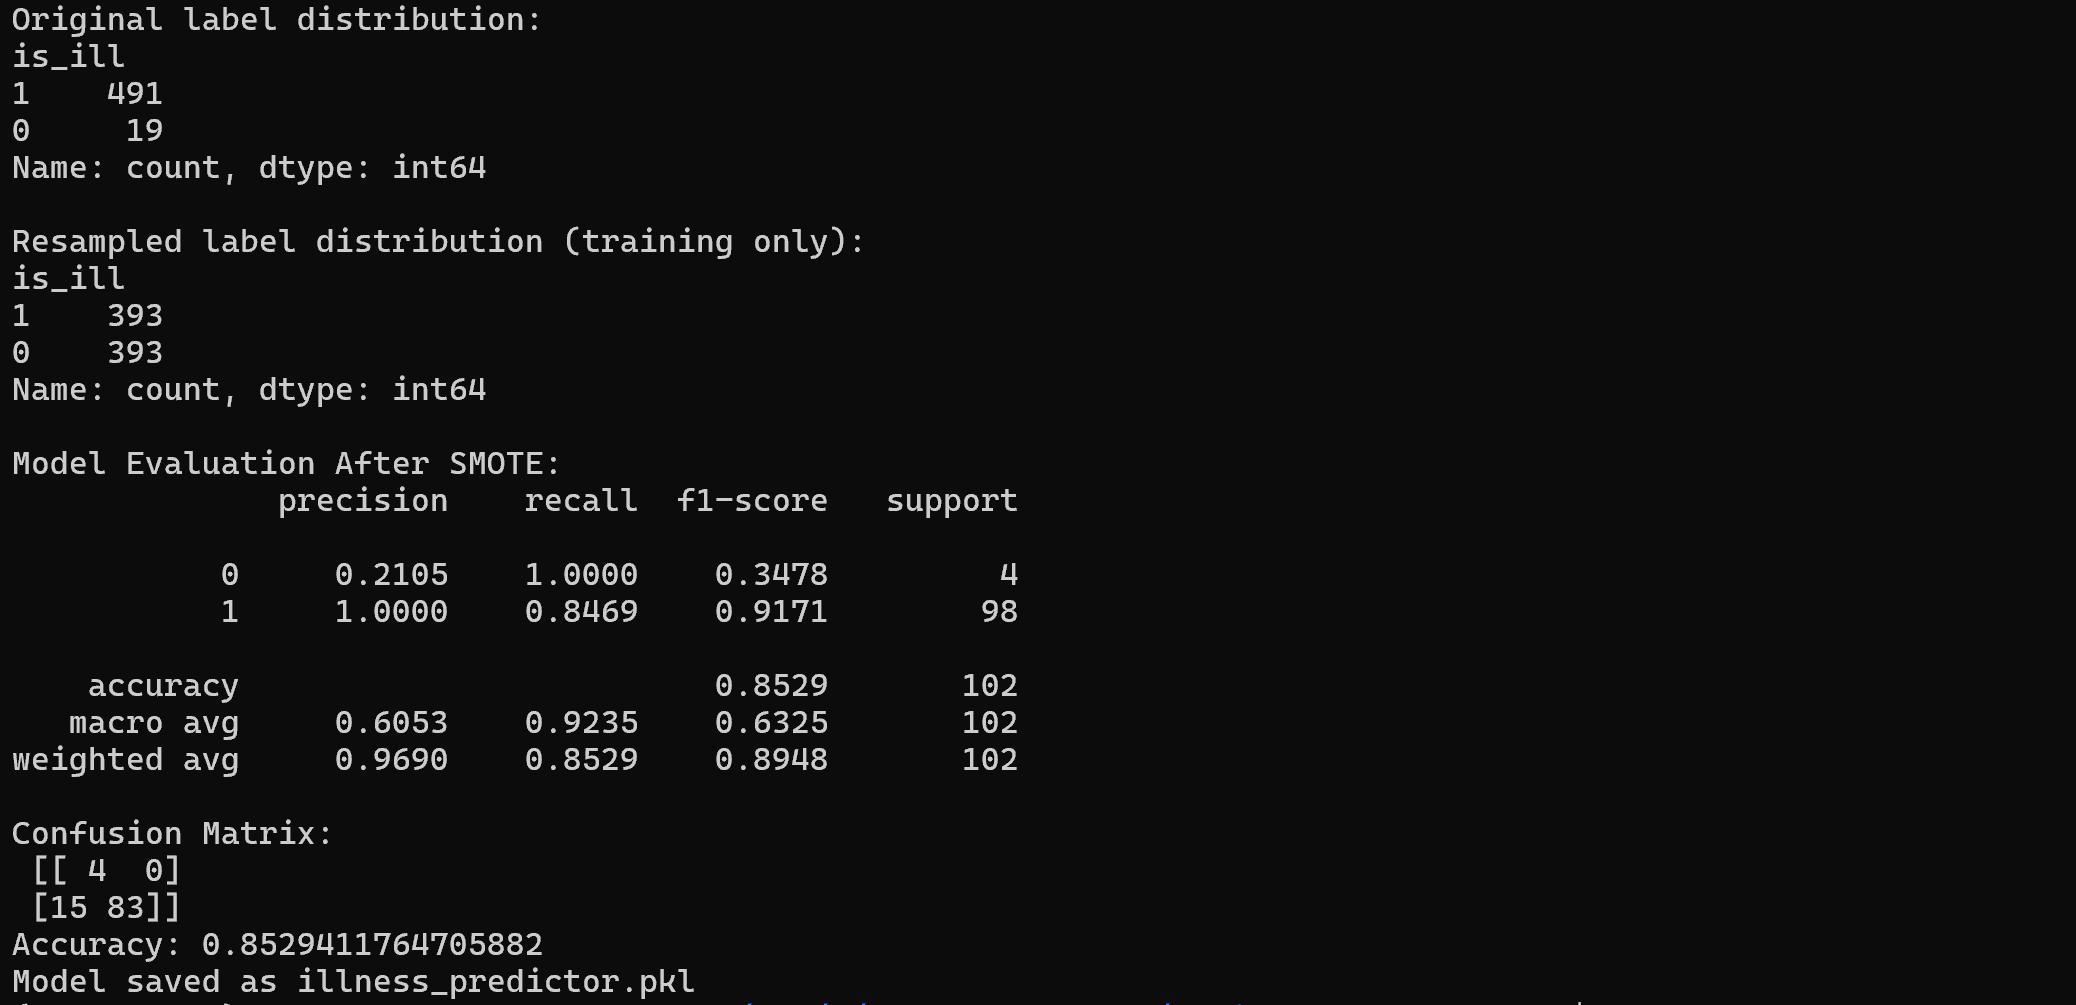

#2. Streaming Data Setup

##Terminal 1 — Start Zookeeper and Kafka

In [ ]:
source ~/venvs/health-env/bin/activate

# Start Zookeeper
cd /PATH_TO/zookeeper/apache-zookeeper-3.9.3-bin
bin/zkServer.sh start

In [ ]:
# Start Kafka
cd /PATH_TO/kafka/kafka_2.13-4.0.0
bin/kafka-server-stop.sh  # Only run if you need to stop an existing Kafka instance
bin/kafka-storage.sh format -t $(bin/kafka-storage.sh random-uuid) -c config/server.properties
bin/kafka-server-start.sh config/server.properties

 The output will show Kafka logs including "Kafka server started" indicating a successful startup.

##Terminal 2 — Create Kafka Topic and Start Data Producer

In [ ]:
source ~/venvs/health-env/bin/activate
cd /PATH_TO/kafka/kafka_2.13-4.0.0

bash bin/kafka-topics.sh --create \
--topic patient_data \
--bootstrap-server localhost:9092 \
--partitions 1 \
--replication-factor 1

In [ ]:
# Ensure dependencies are installed
pip install faker kafka-python

# Run the producer
cd "/PATH_TO_PROJECT"
python src/streaming_data_producer.py

The output will show: Produced: {...} indicating messages are being sent to the patient_data topic:

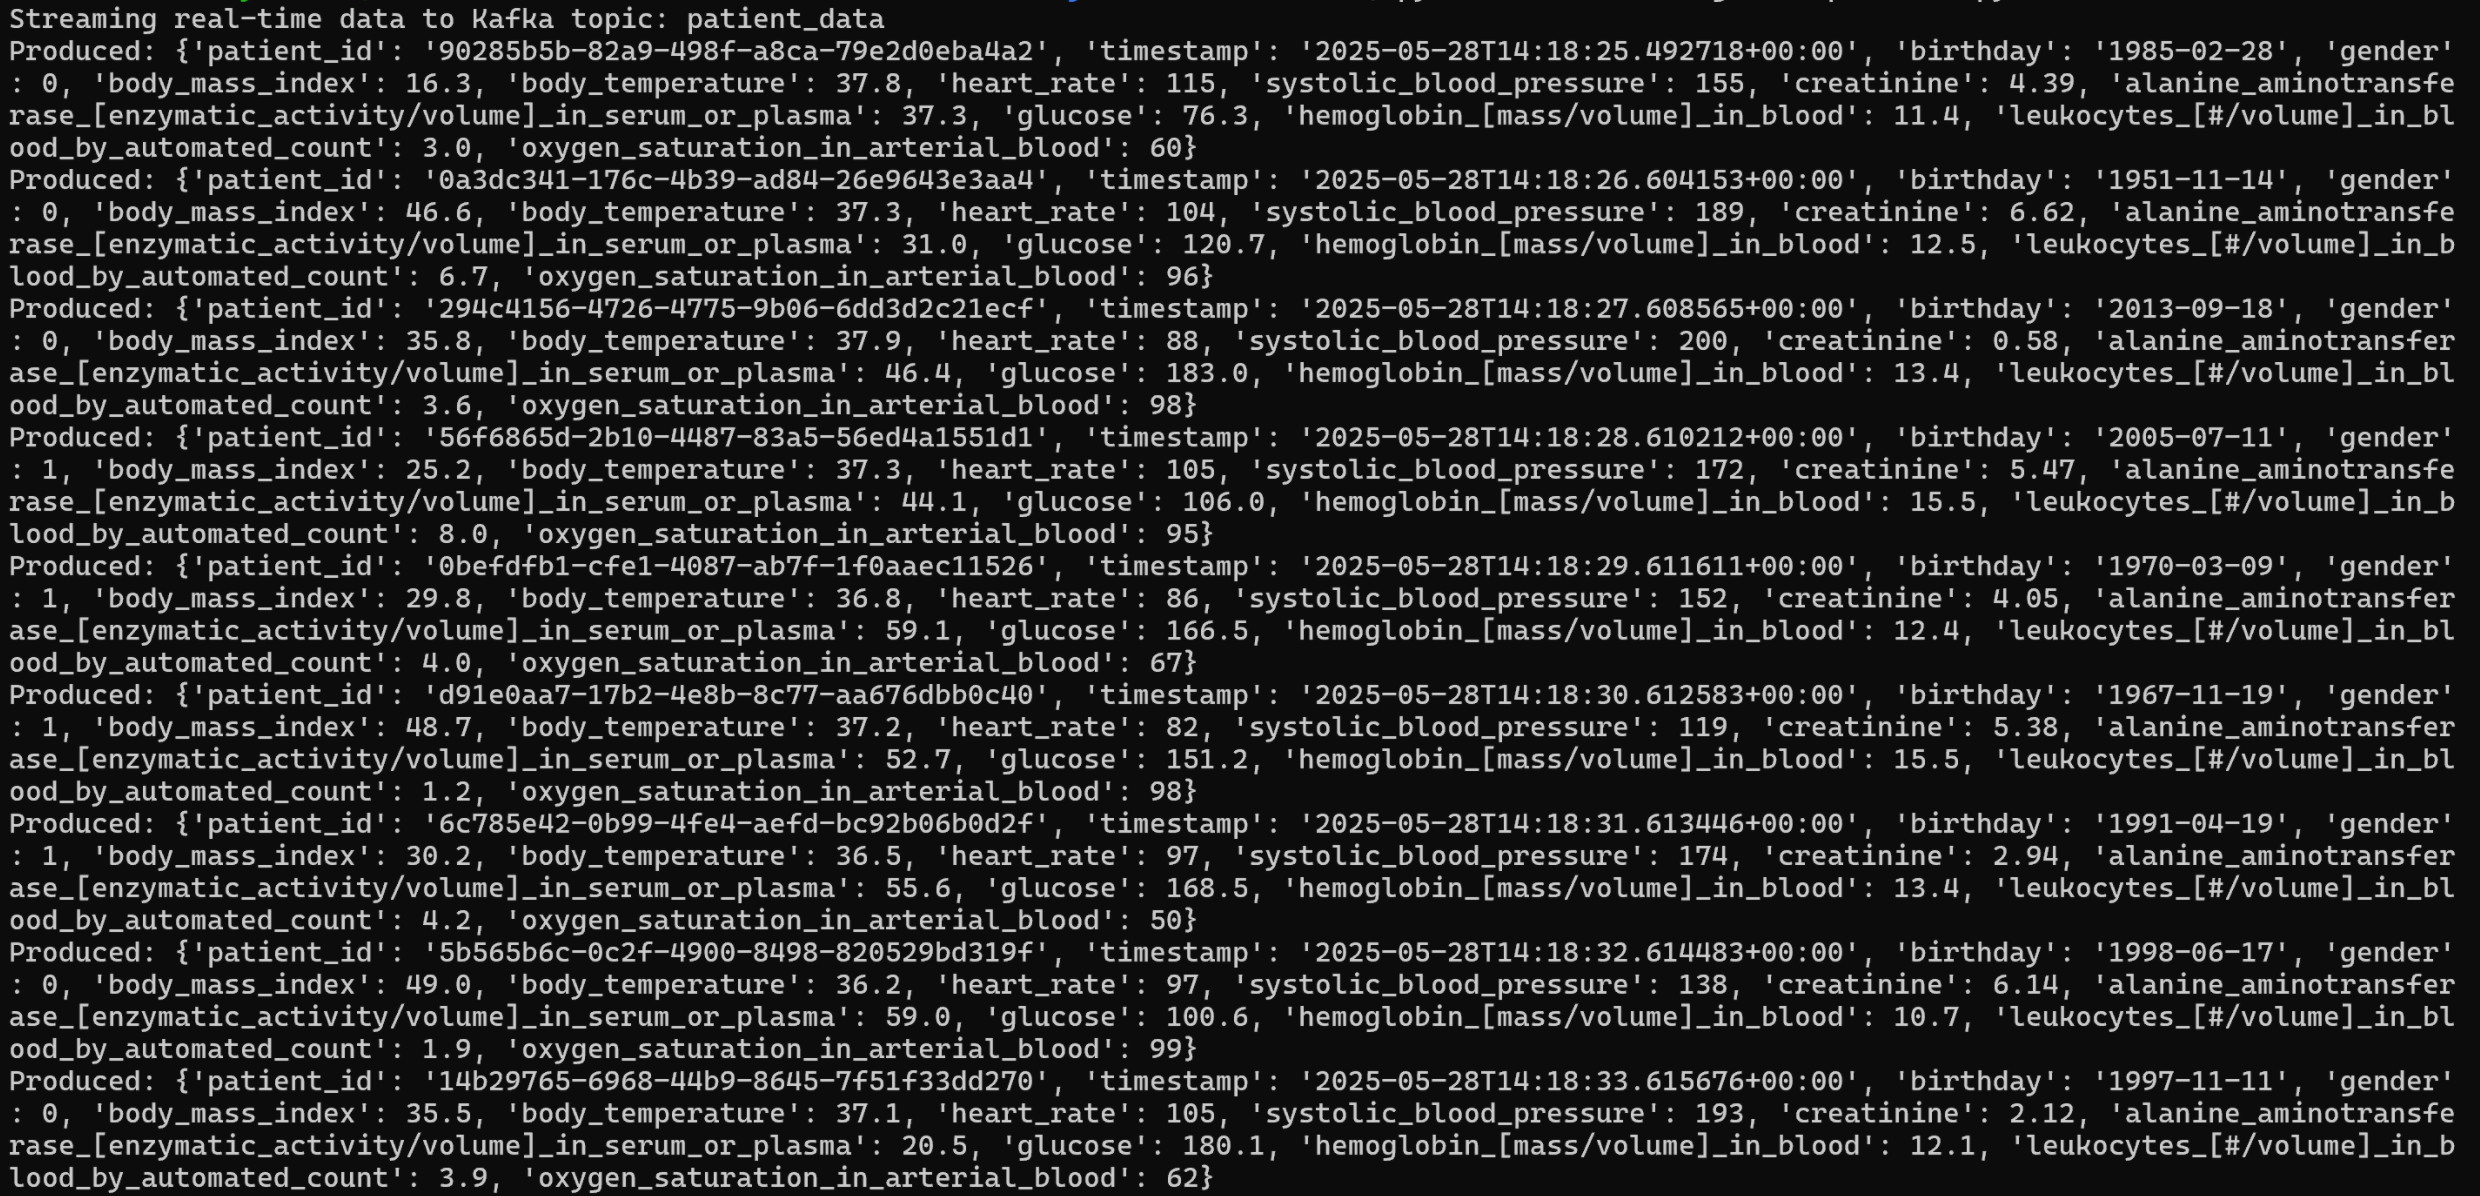

##Terminal 3 — Run Spark Streaming Inference Job

In [ ]:
source ~/venvs/health-env/bin/activate
cd "/PATH_TO_PROJECT"

# Download the JAR
wget https://repo1.maven.org/maven2/com/google/cloud/bigdataoss/gcs-connector/hadoop3-2.2.14/gcs-connector-hadoop3-2.2.14-shaded.jar -P jars/

In [ ]:
spark-submit \
--jars jars/gcs-connector-hadoop3-2.2.14-shaded.jar \
--packages org.apache.spark:spark-sql-kafka-0-10_2.12:3.5.0,\
org.apache.kafka:kafka-clients:3.5.0,\
com.google.cloud.spark:spark-bigquery-with-dependencies_2.12:0.30.0,\
io.delta:delta-core_2.12:2.4.0 \
--conf spark.sql.extensions=io.delta.sql.DeltaSparkSessionExtension \
--conf spark.sql.catalog.spark_catalog=org.apache.spark.sql.delta.catalog.DeltaCatalog \
src/streaming_inference_job.py

You will see the table is created in BigQuery, typically under your specified dataset, and new rows will appear as the stream processes more patient data.

> To stop streaming jobs, press Ctrl + C in each terminal

------------------------------------------